# Tutorial for `snorer`


In this tutorial, I'll briefly go through main classes and functions that are used to evaluate the time-of-flight signature carried by supernova-neutrino-boosted dark matter (SN$\nu$ BDM) due to SN in our Milky Way (MW), Large Magellanic Cloud (LMC) or any in the distant galaxy.


We begin with importing `snorer` and other useful packages in this tutorial. Note that `multiprocessing` is not compatible with jupyter on Mac/Windows systems.
One can alternatively use `ipyparallel` to manifest multiprocessing feature on jupyter. This task is relegated to the reader.

In [2]:
# import complete modules from packages
import multiprocessing as mp
import numpy as np

import snorer
print(f'Current version of snorer: {snorer.__version__}')

import matplotlib.pyplot as plt

# import only necessary modules from packages
from functools import partial

# uncomment this if you have a Hi-DPI monitor and wish to have a better figure resolution
#%matplotlib inline
#%config InlineBackend.figure_format='retina'

Current version of snorer: 0.0.0


## 1 The Useful Constants

We introduce the instance `constant` which contains various useful attributes that are frequently used.
For example the electron mass $m_e$ in MeV can be retrieved by

In [4]:
snorer.constant.me

0.511

Most useful attributes:

- **perMeV2cm** : Convert MeV<sup>−1</sup> to cm
- **year2Seconds** : Convert 1 year to seconds
- **erg2MeV** : Convert 1 erg to MeV
- **kpc2cm** : Convert 1 kpc to cm
- **me** : Electron mass, MeV
- **mn** : Neutron mass, MeV
- **mp** : Proton mass, MeV
- **Msun** : Solar mass $M_\odot$, MeV
- **Msun_kg** : Solar mass $M_\odot$, kg
- **Mmw** : MW stellar mass, $M_\odot$
- **M_SgrA** : The supermassive black hole (SMBH) mass of Sagittarius A*, $M_\odot$
- **Mhalo** : MW DM halo mass, $M_\odot$
- **c** : Speed of light, cm s<sup>−1</sup>
- **H0** : Hubble constant, km s<sup>−1</sup> Mpc<sup>−1</sup>
- **G** : Gravitational constant, ${\rm pc}~M_\odot^{-1}~{\rm (km/s)^2}$
- **SgrA_coord** : Sagittarius A* coordinate in ICRS J2000.0 including distance in kpc, `[RA, DEC, dist]`
- **LMC_coord** : LMC coordinate in ICRS J2000.0 including distance in kpc, `[RA, DEC, dist]`
- **SN1987a_coord** : SN1987a coordinate in ICRS J2000.0 including distance in kpc, `[RA, DEC, dist]`

## 2 The Supernova Energy Spectrum

The total SN$\nu$ flux, including three flavors and anit-species, is given by
$$
\frac{d\phi_\nu}{dE_\nu}=\sum_{i}\frac{L_{\nu_{i}}}{4\pi \ell^{2}\langle E_{\nu_{i}}\rangle}E_{\nu}^{2}f_{\nu_{i}}(E_{\nu})
$$
where $f_\nu (E_\nu)$ is the Fermi-Dirac distribution for neutrinos and $i=e,\mu,\tau$ the (anti-)neutrino flavors.
The SN$\nu$ number density within the shell can be associated with its flux divided by velocity
$$
\frac{dn_\nu}{dE_\nu} = \frac{1}{v}\frac{d\phi_\nu}{dE_\nu}=\frac{d\phi_\nu}{c dE_\nu}
$$
where we assumed neutrino is massless and $v=c$, the light speed.

### 2.a The Useful Functions

#### snorer.snNuSpectrum

`snorer.snNuSpectrum(Ev,D,D_trunct=3.24e-15,is_density=False)` Obtain the SN$\nu$ spctrum after propagating a distance $D$

Parameters:

   - **Ev** : Neutrino energy in MeV, float
   - **D** : Distance from the boosted point to the SN in kpc, float
   - **D_trucnt** : Truncation point for $D$ to prevent divergence when $D<D_{\rm trunc}$ in kpc, float
   - **is_density** : Should the output be flux or number density, bool


Returns:

   - **Spectrum** : Flux (MeV<sup>−1</sup> cm<sup>−2</sup> s<sup>−1</sup>) or
                number density (MeV<sup>−1</sup> cm<sup>−3</sup>)
### 2.b Examples

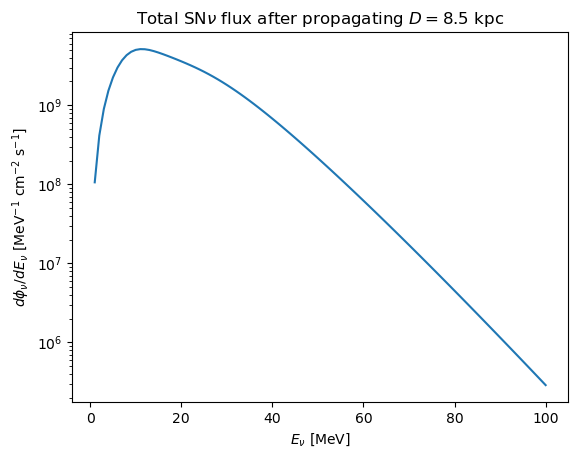

In [21]:
# SNv flux that is 8.5 kpc distant away from the explosion site
D = 8.5
EvList = np.linspace(1,100,100)
SNv_flux = [snorer.snNuSpectrum(Ev,D) for Ev in EvList]  # sigv has no effect whatever value you set 

#　Make the plot
plt.plot(EvList,SNv_flux)
plt.yscale('log')
plt.title(r'Total SN$\nu$ flux after propagating $D=8.5$ kpc')
plt.xlabel(r'$E_\nu$ [MeV]')
plt.ylabel(r'$d\phi_\nu/dE_\nu$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.show()

## 3 The DM Halo Profile

We parametrize the DM halo density profile by
$$
    \rho_\chi(r)=\frac{\rho_s}{\frac{r}{r_s}(1+ \frac{r}{r_s})^n}
$$
where $\rho_s$, $r_s$ and $n$ are the characteristic density, radius and slope of the profile. For number density, it can be obetained by
$$
n_\chi(r,m_\chi) = \frac{\rho_\chi(r)}{m_\chi}.
$$
Furthermore, as suggested in *Phys. Rev. Lett.* **83**, 1719 (1999), DM can form a spike due to SMBH's gravitational pull in the galactic center.
We follow the parametrization for DM profile with spike in the inner galactic region in *JCAP* **06**, 004 (2023) to construct this phenomenon.



### 3.a  The Useful Functions

#### snorer.rhox
`snorer.rhox(r,/,rhos,rs,n)` Obtain DM halo denisty $\rho_\chi$ at $r$

Parameters:

   - **r** : The distance to GC in kpc, float
   - **rhos** : The characteristic density in MeV cm<sup>−3</sup>, float
   - **rs** : The characteristic radius in kpc, float
   - **n** : The slope of the profile, float


Returns:

   - $\rho_\chi(r)$ : DM halo density in MeV cm<sup>−3</sup>, float

#### snorer.dmNumberDensity

`snorer.dmNumberDensity(r,mx,/,is_spike=True,sigv=None,tBH=1e10,profile='MW',alpha='3/2',**kwargs)` Obtain $n_\chi$ at $r$ for a given $m_\chi$

Parameters:
   
   - **r** : The distance to GC in kpc, float
   - **mx** : The DM mass in MeV, float
   - **is_spike** : Turn/off spike feature, bool
   - **sigv** : DM annihilation cross section $\langle\sigma v\rangle$ in the unit of $3\times 10^{-26}~{\rm cm^3~s^{-1}}$, float or **None** indicating no annihilation
   - **tBH** : Age of the SMBH, years
   - **profile** : Which galaxy user's looking into, string, **'MW'** or **'LMC'**
   - **alpha** : Slope of the spike profile, string, **'3/2'** or **'7/3'**
   - **\*\*kwargs** : Keyword arguments that will be passed to the class `HaloSpike`

Returns:

   - $n_\chi(r)$ :  DM halo number density in cm<sup>−3</sup>, float

### 3.b Examples

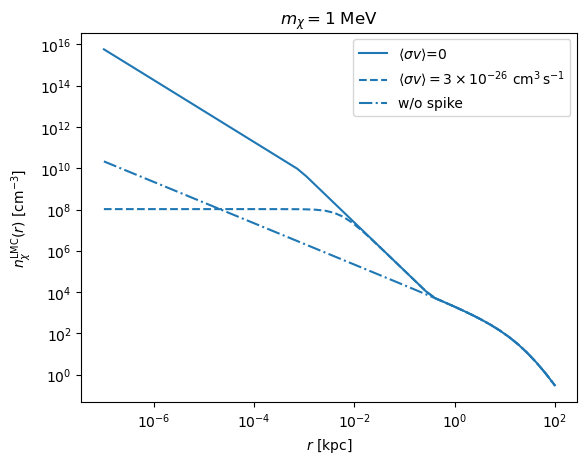

In [14]:
# Display the LMC DM halo number density 
mx = 1
rList = np.logspace(-7,2,50)
nxLMC_sigv0 = [snorer.dmNumberDensity(r,mx,profile='LMC') for r in rList]
nxLMC_sigv3 = [snorer.dmNumberDensity(r,mx,sigv=3,profile='LMC') for r in rList]
nxLMC_nospike = [snorer.dmNumberDensity(r,mx,is_spike=False,profile='LMC') for r in rList]  # sigv has no effect whatever value you set 

#　Make the plot
plt.plot(rList,nxLMC_sigv0,color='C0',label=r'$\langle \sigma v\rangle$=0')
plt.plot(rList,nxLMC_sigv3,'--',color='C0',label=r'$\langle \sigma v\rangle=3\times 10^{-26}~{\rm cm^3\,s^{-1}}$')
plt.plot(rList,nxLMC_nospike,'-.',color='C0',label='w/o spike')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'$m_\chi = 1$ MeV')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$n_\chi^{\rm LMC}(r)~[{\rm cm}^{-3}]$')
plt.show()

### 3.c The Classes

#### snorer.HaloSpike

*class*  `snorer.HaloSpike(mBH,tBH,alpha)`

Class for establishing DM halo number density instance with spike due to SMBH in the galactic center.

Parameters:

 - **mBH** : SMBH mass, $M_\odot$
 - **tBH** : SMBH age, years
 - **alpha** : Slope of the spike profile

*Callable* `__call__(r,mx,/,sigv,rhos,rs,n)` After an instance of `HaloSpike` class is established, it is callable and returns $n_\chi$ at $r$ with spike feature for a given $m_\chi$

Parameters:

 - **r** : The distance to GC in kpc, float
 - **mx** : DM mass in MeV, float
 - **sigv** :  DM annihilation cross section $\langle\sigma v\rangle$ in the unit of $3\times 10^{-26}~{\rm cm^3~s^{-1}}$, float or **None** indicating no annihilation
 - **rhos** : The characteristic density in MeV cm<sup>−3</sup>, float
 - **rs** :  The characteristic radius in kpc, float
 - **n** : The slope of the DM profile, float


Returns:

   - $n_\chi(r)$ :  DM halo number density with spike feature for $m_\chi$ in cm<sup>−3</sup>, float

## 4 The BDM Kinematics

Considering, initially, an incident particle 1 with mass $m_1$ scattered with a target, particle 2, at rest with mass $m_2$.
After the collision, particle 2 received kinetic energy $T_2$ and deflected by an angle $\psi$ in the lab frame.
To have this $2\to2$ scattering happened, we need to derive the required $T_1$.
The interaction is depicted in the following figure.

<div style="text-align:center"><img src="22_scattering.png" alt="2 -> 2 scattering" width="25%" height="auto">

Note that the total energies of the two particles are actually
\begin{align*}
E_{1} & =T_{1}+m_{1},\\
E_{2} & =T_{2}+m_{2}.
\end{align*}
This completely represents the BDM kinematics as particle 1 is neutrino and 2 is DM. Instead of approximating $m_1\to 0$, we derive the kinematics retaining nonzero $m_{1,2}$ for general purpose. Once this is done, we can directly apply it to an *ad hoc* $\nu$-DM scattering.

We firstly introduce the relevant *classes* and then the useful *functions*.

### 4.a The Classes

#### snorer.Kinematics

*class*  `snorer.Kinematics(m1,m2,T2,psi)` 

Class that constructs the required kinetic energy $T_1$ of incoming particle with mass $m_1$ to boost the target with mass $m_2$ to kinetic energy $T_2$. After the collision, the target is deflected by an angle $\psi$ in the lab frame.

Parameters:

 - **m1** : Incident particle mass in MeV, float
 - **m2** : Target mass in MeV, float
 - **T2** : Kinetic energy received by the target in MeV, float
 - **psi** : Lab frame scattering angle in rad ($0\leq \psi\leq \pi$), float

*method* `get_T1()` Obtain the required energy $T_1$

Returns:

   - $T_1$ : The required kinetic energy $T_1$, MeV, of incident particle, float

*method* `get_dT1()` Obtain the Jacobian $\partial T_1/\partial T_2$ that measures the change rate of $T_1$ according to $T_2$

Returns:

   - $\partial T_1/\partial T_2$ : The Jacobian, float

*method* `get_sanity()`  Does particle 1 really can scatter particle 2 to have $(T_\chi,\psi)$ 

Returns:

   - bool : **True** means yes and **False** means otherwise. **False** usually means the required $T_1$ is negative, which is clearly insane.

*method* `get_dLips()`  Obtain the Lorentz invariant phase space, dLips,
$$
\left. \frac{d\sigma_{\chi\nu}}{d\Omega}\right|_\psi=\frac{1}{2\pi}\frac{du}{d\cos\psi}\frac{d\sigma_{\chi\nu}}{du}={\rm dLips}~|\mathcal{M}|^2
$$
where $|\mathcal{M}|^2$ is the square of the scattering amplitude.
This gives you the differential $\nu$-DM cross section at $\psi$ direction, but only works for $|\mathcal{M}|^2$ is known. For model-independent case, we have another easier way to obtain the angular distribution `fx_lab()`.
 
Returns:

   - dLips : The Lorentz invariant phase space in ${\rm cm^2~sr^{-1}}$, float

#### snorer.Neutrino

*class*  `snorer.Neutrino(mx,Tx,psi)` 

Bear in mind with the general kinematics of non-zero particles $m_{1,2}$ scattering. We can apply it to a more simple case that has $m_1=m_\nu=0$, $m_2=m_\chi$ and $T_2=T_\chi$.
Under this setup, we will have
\begin{align*}
E_{\nu} & =T_{\nu},\\
E_{\chi} & =T_{\chi}+m_{\chi}.
\end{align*}

Parameters:

 - **mx** : DM mass in MeV, float
 - **Tx** : DM kinetic energy in MeV, float
 - **psi** : DM lab frame scattering angle in rad ($0\leq \psi\leq \pi$), float

*attribute* **Ev** : The SN$\nu$ energy $E_\nu$ in MeV, float

*attribute* **dEv** : The Jacobian $\partial E_\nu/\partial T_\chi$, float

*attribute* **is_sanity** : Is this process allowed kinematically, bool



### 4.b The Useful Functions

#### snorer.get_vx

`snorer.get_vx(Tx,mx)`  Obtain BDM velocity $v_\chi \in [0,1)$ in the unit of $c$

Parameters:

   - **Tx** : The BDM kinetic energy, float
   - **mx** : The DM mass in MeV, float


Returns:

   - $v_\chi$ : BDM velocity in the unit of $c$, float

#### snorer.fx_lab

`snorer.fx_lab(Ev,mx,psi)`  Obtain the angular distribution of $\nu$-DM cross section at $\psi$
$$
\left.\frac{d\sigma_{\chi\nu}}{d\Omega_{\rm lab}}\right|_\psi = f_\chi(E_\nu,m_\chi,\psi)\times \sigma_{\chi\nu,0}
$$

Parameters:

   - **Ev** : The SN$\nu$ energy in MeV, float
   - **mx** : The DM mass in MeV, float
   - **psi** : DM lab frame scattering angle in rad ($0\leq \psi\leq \pi$), float 


Returns:

   - $f_\chi$ : Angular distribution in ${\rm sr}^{-1}$, float

#### snorer.get_thetaRange

`snorer.get_thetaRange(t,Tx,mx,psi)`  Obtain the range of zenith angle that contains non-zero BDM flux

Parameters:

  - **t** : The BDM arrival time in seconds, float
  - **Tx** : DM kinetic energy in MeV, float
  - **mx** : DM mass in MeV, float
  - **psi** : DM lab frame scattering angle in rad ($0\leq \psi\leq \pi$), float

Returns:

   - tuple : $(\theta_{\rm min},\theta_{\rm max})$ in rad

#### snorer.get_tof

`snorer.get_tof(t,Tx,mx,psi)`  Obtain the BDM peak time $t_{\rm peak}$ and vanishing time $t_{\rm van}$

Parameters:

  - **Tx** : DM kinetic energy in MeV, float
  - **mx** : DM mass in MeV, float
  - **Rstar** : Distance to SN in kpc, float

Returns:

   - tuple : $(t_{\rm peak},t_{\rm van})$ in seconds

## 5 The BDM Afterglow and Event Number

## 6 The Astrophysical Relations

### 6.a $M-\sigma$ relation

The stellar velocity dispersion $\sigma_star$ in the galactic bulge under the influence of SMBH with mass $M_{\rm BH}$
$$
\log_{10}\left(\frac{M_{\rm BH}}{M_\odot}\right) = 8.29+5.12 \log_{10} \left( \frac{\sigma_\star}{200~{\rm km~s^{-1}}}\right)
$$
See *Nature* **480**, 215 (2011).

### 6.b SMBH Influence Radius

The SMBH influence radius $r_h$ is defined by
$$
r_h = \frac{G M_{\rm BH}}{\sigma_\star^2}
$$

### 6.c Schwarzschild Radius

The Schwarzschild radius $R_S$ of a BH is defined by
$$
R_S = \frac{2G M_{\rm BH}}{c^2}
$$

### 6.d The Useful Functions

#### snorer.M_sigma
`snorer.M_sigma(mBH)` Obtain $\sigma_\star$ for BH mass $M_{\rm BH}$

Parameters:

   - **mBH** : The BH mass in $M_\odot$, float

Returns:

   - $\sigma_\star$ : stellar velocity dispersion in km/s, float

#### snorer.radiusInfluence

`snorer.radiusInfluence(mBH)` Obtain $r_h$ for BH mass $M_{\rm BH}$

Parameters:
   
   - **mBH** : The BH mass in $M_\odot$, float

Returns:

   - $r_h$ :  The influence radius in kpc, float

#### snorer.radiusSchwarzschild

`snorer.radiusSchwarzschild(mBH)` Obtain $R_S$ for BH mass $M_{\rm BH}$

Parameters:
   
   - **mBH** : The BH mass in $M_\odot$, float

Returns:

   - $R_S$ :  The Schwarzschild radius in kpc, float